# Result analysis

In [1]:
import csv

import numpy as np

try:
    from gensim import models
except ModuleNotFoundError as e:
    !pip install gensim==3.8.0
    from gensim import models
try:
    import pandas as pd
except ModuleNotFoundError as e:
    !pip install pandas
    import pandas as pd
    
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError as e:
    !pip install matplitlib
    import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Function to lead data

In [2]:
def prepare_data(model_path, data_prefix, seq_len, embedding_size):
    """Function to read specified data and organize it in the desired way
    
    Args:
        model_path (str): path to embedding model
        data_prefix (str): path to data prefix
        seq_len (int): length of each training observation
        embedding_size (int): size of the embedding
    
    """
    
    def load_data(path):
        output = []
        
        with open(path, 'r', encoding='latin-1') as data:
        #with open(path, 'r', encoding='utf-8') as data:
            for row in csv.reader(data):
                output.append(row)
                
        return output
    
    # Opens embedding model
    model_ = models.Word2Vec.load(model_path)
    
    # Open dataset
    data_train = load_data(data_prefix + "X_train.csv")
    data_val = load_data(data_prefix + "X_val.csv")
    data_test = load_data(data_prefix + "X_test.csv")
    label_train = np.loadtxt(data_prefix + "y_train.csv")
    label_val = np.loadtxt(data_prefix + "y_val.csv")
    label_test = np.loadtxt(data_prefix + "y_test.csv")
    
    # Gets embeddings from model
    dt = []
    lt = []
    omissions_ = 0
    
    for i, seq in enumerate(data_train):
        
        try:        
            embedding = model_.wv[seq]
            dt.append(embedding)
            lt.append(label_train[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
            
#     print(omissions_)
    
    # Gets embeddings from model
    dv = []
    lv = []
    omissions_ = 0
    
    for i, seq in enumerate(data_val):
        
        try:
            embedding = model_.wv[seq]
            dv.append(embedding)
            lv.append(label_val[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
            
    # Gets embeddings from model
    dtest = []
    ltest = []
    omissions_ = 0
    
    for i, seq in enumerate(data_test):
        try:
            embedding = model_.wv[seq]
            dtest.append(embedding)
            ltest.append(label_test[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
    
#     print(omissions_)
    
    # Pads sequences
    dt = pad_sequences(dt, padding='post', dtype='float64', maxlen=seq_len)
    dv = pad_sequences(dv, padding='post', dtype='float64', maxlen=seq_len)
    dtest = pad_sequences(dtest, padding='post', dtype='float64', maxlen=seq_len)
    
    # Converts lists to numpy arrays
#     dt = np.asarray(dt).reshape((len(dt), seq_len * embedding_size))
#     dv = np.asarray(dv).reshape((len(dv), seq_len * embedding_size))
    
    lt = np.asarray(lt)
    lv = np.asarray(lv)
    ltest = np.asarray(ltest)
    
    return dt, dv, lt, lv, dtest, ltest

In [3]:
def create_RNN_model(embedding_size, seq_len, classes, input_shape):
    """
    Function to create RNN model
    
    Args:
        embedding_size (int): Size of the embedding to be used
        seq_len (int): length of each training observation
        classes (int): number of possible classes
        input_shape (int): Shape in which the input will be provided
    
    Returns:
        tensorflow.python.keras.enresourcesgine.sequential.Sequential: RNN model 
    """
    
    model = keras.Sequential([
        layers.SimpleRNN(units = embedding_size, input_shape=input_shape),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/8, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

def create_LSTM_model(embedding_size, seq_len, classes, input_shape):
    """
    Function to create LSTM model
    
    Args:
        embedding_size (int): Size of the embedding to be used
        seq_len (int): length of each training observation
        classes (int): number of possible classes
        input_shape (int): Shape in which the input will be provided
    
    Returns:
        tensorflow.python.keras.engine.sequential.Sequential: LSTM model 
    """
    
    model = keras.Sequential([
        layers.LSTM(units = embedding_size, input_shape = input_shape),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/8, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model
# Dictionary to store model creators
model_creators = {'SimpleRNN': create_RNN_model,
                  'LSTM': create_LSTM_model}

In [9]:
simpson_dict = {15: "./resources/embeddings/Simpsons_15_7.model",
                75: "./resources/embeddings/Simpsons_75_7.model",
                150: "./resources/embeddings/Simpsons_150_7.model",
                'prefix': "./data/simpsons/",
                'classes': 4,
               'weights':{0:2.5, 1:1, 2:3, 3:2.5}}

friends_dict = {15: "./resources/embeddings/Friends_15_7.model",
                75: "./resources/embeddings/Friends_75_7.model",
                150: "./resources/embeddings/Friends_150_7.model",
                'prefix': "./data/friends/",
                'classes': 6,
               'weights':{0: 1, 1:1, 2:1, 3:1, 4:1, 5:1}}

In [18]:
def train_val_model(dataset, em_size, seq_len, model_type, epochs):
    """
    Function to train the given model
    
    Args:
        dataset (str): Name of the dataset to use
        em_size (int): size of the embedding to load
        seq_len (int): lenght of each observation
        model_type (str): model to train
        epochs (int): total epochs to train the model for
    
    Returns:
        PENDING.
    """
    
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'

    print(em_size)
    dt, dv, lt, lv, dtest, ltest = prepare_data(data_path[em_size], data_path['prefix'], seq_len, em_size)
    
    data = {'X_train': dt+dv, 'X_test': dtest, 'y_train': lt+lv, 'y_test':ltest}
    
    
    input_shape = (seq_len, em_size)
    
    model = model_creators[model_type](em_size, seq_len, data_path['classes'], 
                                       input_shape=input_shape)
    history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_train'],data['y_val']), 
                        epochs = epochs, verbose = 0, 
                        class_weight=data_path['weights'])
    return model

In [41]:
def get_model_results(dataset, embedding):
    """
    """
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'
    
    if embedding not in ['deepModels', 'embeddingModels']:
        raise 'Not valid embedding type'
        
    results_path = './results/' + dataset + '/' + embedding + '.csv'
    results_df = pd.read_csv(results_path)
    best_model = results_df[results_df.val_f1 == results_df.val_f1.max()]
    
    model_retrained = train_val_model(dataset, 
                                      best_model['embedding_size'][best_model['embedding_size'].index[0]],
                                      best_model['seq_len'][best_model['seq_len'].index[0]], 
                                      best_model['model_name'][best_model['model_name'].index[0]], 20)
    
    path = './results/' + dataset + '/checkpoints/'
    path = path + best_model['model_name'] + '_' + str(best_model['embedding_size']) + '_' 
    path = path + str(best_model['seq_len'])
    print(path)
    model_loaded = tf.keras.models.load_model(path)
    
    X_train, X_val, y_train, y_val, X_test, y_test = prepare_data(data_path[em_size], 
                                                                  data_path['prefix'], 
                                                                  best_model['seq_len'], 
                                                                  best_model['embedding_size'])
    
    y_pred_train = model_loaded.predict(X_train)
    y_pred_val = model_loaded.predict(X_val)
    y_pred_test = model_retrained(X_test)
    
    return y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test

In [42]:
y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test = get_model_results('simpson', 'deepModels')

150


ValueError: operands could not be broadcast together with shapes (26396,35,150) (5462,35,150) 

In [ ]:
deepModels_simpson = pd.read_csv('./results/simpson/deepModels.csv')
deepModels_friends = pd.read_csv('./results/friends/deepModels.csv')

embeddings_simpson = pd.read_csv('./results/simpson/embeddingModels.csv')
embeddings_friends = pd.read_csv('./results/friends/embeddingModels.csv')

In [ ]:
# Reentrenar modelos con embedding adentro usando datos de entrenamiento y validacion

## Results from all models

### Select best models

In [108]:
dt, dv, lt, lv, dtest, ltest = prepare_data('./resources/embeddings/Simpsons_'+str(best_deep_simpson['embedding_size'])+'_7.model',
                                            './data/simpsons/', 
                                            best_deep_simpson['seq_len'],
                                            best_deep_simpson['embedding_size'])
simpson_dict = {'X_train': dt, 'X_val': dv, 'X_test': dtest,
               'y_train': lt, 'y_val': lv, 'y_test':ltest}

In [22]:
deepModels_simpson = pd.read_csv('./results/simpson/deepModels.csv')

In [23]:
best_deep_simpson = deepModels_simpson[deepModels_simpson.val_accuracy == deepModels_simpson.val_accuracy.max()]

In [26]:
best_deep_simpson

,Unnamed: 0,model_name,embedding_size,seq_len,train_accuracy,train_precision,train_recall,train_f1,val_accuracy,val_precision,val_recall,val_f1
23,0,LSTM,150,35,0.606265,0.608808,0.606265,0.60099,0.4396,0.440665,0.4396,0.434091


In [37]:
best_deep_simpson['embedding_size'].index[0]

23

In [110]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(simpson_dict['X_test']), axis=1)

<AxesSubplot:>

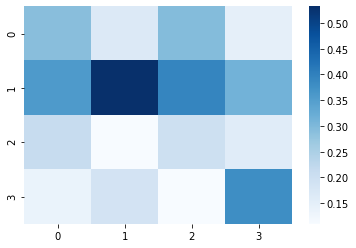

In [118]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(simpson_dict['y_test'], axis=1), y_pred, normalize='pred'), cmap='Blues')

In [116]:
confusion_matrix(np.argmax(simpson_dict['y_test'], axis=1), y_pred, normalize='true')

array([[0.31624674, 0.35013032, 0.19808862, 0.13553432],
       [0.19140791, 0.53934496, 0.12973203, 0.1395151 ],
       [0.31529412, 0.30823529, 0.18117647, 0.19529412],
       [0.15641953, 0.40596745, 0.07775769, 0.35985533]])